# Complete Experiment: Baseline vs Q-Learning vs PPO

**Run this notebook to execute the full experiment**

- Baseline (no RL)
- Q-Learning (table RL)
- PPO (neural RL)

Expected time: ~20-30 minutes

In [1]:
# ============================================================================
# COMPLETE EXPERIMENT: Baseline vs Q-Learning vs PPO
# ============================================================================
# This is your COMPLETE experiment with all 3 methods
# Copy each ### CELL X: section into separate notebook cells
# ============================================================================

### CELL 1: Setup - Imports ###
import sys
import os
import json
import datetime
import random
import numpy as np
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
from dataclasses import dataclass

# Fix path for notebook - go up one level to project root
PROJECT_ROOT = Path.cwd().parent  # Go up from notebooks/ to project root
SRC = PROJECT_ROOT / "src"
LOGS_DIR = PROJECT_ROOT / "logs"

if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Change working directory to project root
os.chdir(PROJECT_ROOT)

# Create logs directory if it doesn't exist
LOGS_DIR.mkdir(exist_ok=True)

print(f" Project root: {PROJECT_ROOT}")
print(f" Current working directory: {Path.cwd()}")
print(f" SRC path: {SRC}")
print(f" Logs directory: {LOGS_DIR}")
print(f" Logs directory exists: {LOGS_DIR.exists()}")
print(f" Setup complete")

 Project root: c:\Users\maitha.alhammadi\RL_2025
 Current working directory: c:\Users\maitha.alhammadi\RL_2025
 SRC path: c:\Users\maitha.alhammadi\RL_2025\src
 Logs directory: c:\Users\maitha.alhammadi\RL_2025\logs
 Logs directory exists: True
 Setup complete


In [2]:
### CELL 2: Load Backend ###
from dotenv import load_dotenv
load_dotenv()

from backend.rl_agent import RLAgent
from backend.ppo_agent import PPOAgent  # ADD PPO!
from backend.state import encode_state
from backend.retrieval_policies import action_to_filter
from backend.rag_process import rag_process
from backend.reward_enhanced import calculate_enhanced_reward
from backend.utils_async import run_async

print(" Backend loaded (Q-Learning + PPO)")

c:\Users\maitha.alhammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maitha.alhammadi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Backend loaded (Q-Learning + PPO)


In [3]:
### CELL 3: API Clients ###
from openai import OpenAI
from groq import AsyncGroq

OPENAI_AVAILABLE = True
GROQ_AVAILABLE = True

try:
    openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    if openai_client.api_key:
        print(" OpenAI ready")
    else:
        OPENAI_AVAILABLE = False
except:
    OPENAI_AVAILABLE = False

try:
    groq_client = AsyncGroq(api_key=os.getenv("GROQ_API_KEY"))
    if os.getenv("GROQ_API_KEY"):
        print(" Groq ready")
    else:
        GROQ_AVAILABLE = False
except:
    GROQ_AVAILABLE = False

print(f"APIs: OpenAI={OPENAI_AVAILABLE}, Groq={GROQ_AVAILABLE}")

 OpenAI ready
 Groq ready
APIs: OpenAI=True, Groq=True


In [4]:
### CELL 4: Small Model RAG ###
class SmallModelRAG:
    def __init__(self, model_name: str = "llama-3.1-8b-instant", max_tokens: int = 600, temperature: float = 0.3):
        self.model_name = model_name
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.rag = rag_process()
        print(f" SmallModelRAG: {model_name} (max_tokens={max_tokens})")
    
    def query_documents(self, question: str, action: str, n_results: int = 4):
        try:
            metadata_filter = action_to_filter(action) or None
            print(f" Querying with action '{action}' -> filter: {metadata_filter}")
            chunks, metas = self.rag.query_documents(
                question=question, 
                n_results=n_results, 
                metadata_filter=metadata_filter
            )
            print(f" Retrieved {len(chunks)} chunks")
            return chunks, metas
        except Exception as e:
            print(f" RAG query failed: {e}")
            return [], []
    
    async def generate_response_with_groq(self, question: str, chunks: List[str], context: str) -> str:
        try:
            if not GROQ_AVAILABLE:
                return "Groq not available"
            
            # Let LLM answer naturally using both context and its knowledge
            messages = [
                {"role": "system", "content": "You are a helpful GHG emissions consultant. Use the provided context to give accurate answers."},
                {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"}
            ]
            
            response = await groq_client.chat.completions.create(
                messages=messages,
                model=self.model_name,
                temperature=self.temperature,
                max_tokens=self.max_tokens
            )
            
            return response.choices[0].message.content
        except Exception as e:
            return f"Error: {str(e)}"
    
    def generate_response_sync(self, question: str, chunks: List[str], context: str) -> str:
        return run_async(self.generate_response_with_groq(question, chunks, context))

# Create TWO different RAG instances:
# 1. Baseline: Short answers (basic quality)
baseline_rag = SmallModelRAG(max_tokens=200, temperature=0.7)
print(" Baseline RAG ready")

# 2. RL methods: Full answers (better quality)
rl_rag = SmallModelRAG(max_tokens=600, temperature=0.3)
print(" RL RAG ready")

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


 SmallModelRAG: llama-3.1-8b-instant (max_tokens=200)
 Baseline RAG ready


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


 SmallModelRAG: llama-3.1-8b-instant (max_tokens=600)
 RL RAG ready


In [5]:
### CELL 5: OpenAI Judge ###
@dataclass
class JudgeResult:
    score: float
    reward: float
    rationale: str
    verdict: str

class OpenAIJudge:
    def __init__(self, model: str = "gpt-4o-mini"):
        self.model = model
        self.client = openai_client
    
    def evaluate_answer(self, question: str, chunks: List[str], agent_answer: str) -> JudgeResult:
        try:
            if not OPENAI_AVAILABLE:
                return JudgeResult(0.0, -1.0, "OpenAI unavailable", "thumbs_down")
            
            context = "\n\n".join(chunks) if chunks else "No context"
            
            system_prompt = """You are a QUALITY-focused evaluator. Rate answers 0.0-1.0 based on:
            1. DETAIL: Is the answer comprehensive and detailed? (40% weight)
            2. ACCURACY: Is the information correct? (30% weight)
            3. COMPLETENESS: Does it fully answer the question? (20% weight)
            4. CONTEXT USAGE: Does it use the provided context? (10% weight)
            
            SHORT, basic answers should get 0.5-0.6 (thumbs_down)
            DETAILED, comprehensive answers should get 0.8-1.0 (thumbs_up)
            
            - Score 0.7-1.0: thumbs_up (detailed, comprehensive answer)
            - Score 0.0-0.6: thumbs_down (short, basic, or incomplete answer)
            Return JSON: {"score": 0.0-1.0, "verdict": "thumbs_up"|"thumbs_down", "rationale": "why"}"""
            
            user_prompt = f"QUESTION: {question}\n\nCONTEXT: {context}\n\nANSWER: {agent_answer}\n\nEvaluate:"
            
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.0,
                max_tokens=300
            )
            
            content = response.choices[0].message.content.strip()
            try:
                result_data = json.loads(content)
                score = float(result_data.get("score", 0.0))
                verdict = result_data.get("verdict", "thumbs_down")
                rationale = result_data.get("rationale", "")
            except:
                score = 0.7 if "thumbs_up" in content.lower() else 0.3
                verdict = "thumbs_up" if score >= 0.7 else "thumbs_down"
                rationale = content
            
            reward = 1.0 if score >= 0.85 else (0.3 if score >= 0.65 else -1.0)
            
            return JudgeResult(score, reward, rationale, verdict)
        except Exception as e:
            return JudgeResult(0.0, -1.0, f"Error: {e}", "thumbs_down")

judge = OpenAIJudge()
print(" Judge ready")

 Judge ready


In [6]:
### CELL 6: Load Questions ###
# GHG Consulting Test Questions - Enhanced with variety (short/medium/long)
TRAINING_QUESTIONS = [
    # SHORT GHG (< 80 chars) 
    {"question": "What is Scope 1 emissions?", "category": "ghg"},
    {"question": "What is Scope 2 emissions?", "category": "ghg"},
    {"question": "What is Scope 3 emissions?", "category": "ghg"},
    
    # MEDIUM GHG (80-200 chars)
    {"question": "How do you calculate GHG emissions?", "category": "ghg"},
    {"question": "What are the GHG Protocol standards?", "category": "ghg"},
    {"question": "What are the different scopes of emissions in the GHG Protocol?", "category": "ghg"},
    {"question": "How can companies reduce their Scope 3 emissions?", "category": "ghg"},
    {"question": "What are science-based targets?", "category": "ghg"},
    {"question": "How do you conduct a GHG inventory?", "category": "ghg"},
    {"question": "What are the key challenges in measuring Scope 3 emissions?", "category": "ghg"},
    {"question": "How do emission factors work in GHG calculations?", "category": "ghg"},
    
    # LONG GHG (200+ chars) - NEW!
    {"question": "Can you explain the comprehensive process for calculating Scope 3 emissions across the entire value chain, including upstream and downstream activities, with specific examples of emission factors and calculation methodologies for different categories of indirect emissions?", "category": "ghg"},
    
    # SHORT LEGAL (< 80 chars)
    {"question": "What is the Paris Agreement?", "category": "legal"},
    
    # MEDIUM LEGAL (80-200 chars)
    {"question": "What are the reporting requirements for GHG emissions?", "category": "legal"},
    {"question": "What is the Paris Agreement's temperature goal and why is it significant?", "category": "legal"},
    {"question": "What is the TCFD framework?", "category": "legal"},
    
    # LONG LEGAL (200+ chars) - NEW!
    {"question": "According to the Paris Agreement and its subsequent amendments, what are the comprehensive legal obligations for developed nations regarding emissions reductions, financial support for developing countries, and the transparency framework for reporting progress?", "category": "legal"},
    
    # SHORT FINANCE (< 80 chars)
    {"question": "What is carbon accounting?", "category": "fin"},
    
    # MEDIUM FINANCE (80-200 chars)
    {"question": "How do companies report their carbon footprint?", "category": "fin"},
    {"question": "What are carbon offsets and how do they work?", "category": "fin"},
    {"question": "What is the difference between market-based and location-based accounting?", "category": "fin"},
    
    # LONG FINANCE (200+ chars) - NEW!
    {"question": "What are the detailed financial implications and cost-benefit analyses companies should consider when implementing a comprehensive carbon accounting system, including the initial investment, ongoing operational costs, potential carbon tax liabilities, and the financial benefits of emission reductions?", "category": "fin"},
]

print(f" {len(TRAINING_QUESTIONS)} questions loaded")

 22 questions loaded


In [7]:
### CELL 7: Baseline Test Function ###
def test_baseline(rag, questions, num_tests=50):
    """TRUE BASELINE: Simple LLM answering questions without any retrieval strategy
    
    Strategy:
    - No action selection, no retrieval optimization
    - Just answer questions using basic RAG (always broad search)
    - This is the "naive" system that RL methods should improve upon
    """
    print(f"\n{'='*70}\n TRUE BASELINE TEST (No Strategy Learning)\n{'='*70}\n")
    
    results = []
    for i, q in enumerate(random.sample(questions, min(num_tests, len(questions)))):
        question = q["question"]
        
        # SIMPLE UNTRAINED BOT: Random action selection (no learning)
        action = random.choice(["broad", "legal_only", "financial_only", "company_only"])
        chunks, _ = rag.query_documents(question, action, 4)  # Get some chunks
        context = "\n\n".join(chunks) if chunks else ""
        answer = rag.generate_response_sync(question, chunks, context)
        result = judge.evaluate_answer(question, chunks, answer)
        
        # Simple output like you want
        print(f"Question: {question}")
        print(f"Untrained_bot answer: {answer[:100]}...")
        print(f"{result.verdict}")
        print()
        
        # Store detailed results
        detailed_result = {
            "question_number": i+1,
            "question": question,
            "action": action,
            "chunks_retrieved": chunks,
            "context": context,
            "answer": answer,
            "score": result.score,
            "verdict": result.verdict,
            "method": "Baseline (No Strategy)"
        }
        results.append(detailed_result)
    
    avg = sum(r["score"] for r in results) / len(results)
    up_rate = sum(1 for r in results if r["verdict"] == "thumbs_up") / len(results) * 100
    
    # Save detailed results to files
    import json
    import csv
    from datetime import datetime
    
    # Save to JSON (overwrite each time)
    json_filename = f"logs/baseline/baseline_detailed_results.json"
    with open(json_filename, 'w') as f:
        json.dump({
            "summary": {
                "method": "Baseline (No Strategy)",
                "avg_score": avg,
                "success_rate": up_rate,
                "total_questions": len(results),
                "timestamp": datetime.now().isoformat()
            },
            "detailed_results": results
        }, f, indent=2)
    
    # Save to CSV (overwrite each time)
    csv_filename = f"logs/baseline/baseline_detailed_results.csv"
    with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Question_Number', 'Question', 'Action', 'Answer', 'Score', 'Verdict', 'Method'])
        
        for result in results:
            writer.writerow([
                result['question_number'],
                result['question'],
                result['action'],
                result['answer'][:500] + "..." if len(result['answer']) > 500 else result['answer'],  # Truncate long answers
                result['score'],
                result['verdict'],
                result['method']
            ])
    
    print(f"\n{'='*70}")
    print(f" BASELINE RESULTS")
    print(f"{'='*70}")
    print(f"Average Score: {avg:.3f}")
    print(f"Success Rate: {up_rate:.1f}%")
    print(f" Detailed results saved to:")
    print(f"   JSON: {json_filename}")
    print(f"   CSV:  {csv_filename}")
    print(f"{'='*70}\n")
    
    return {"results": results, "avg_score": avg, "success_rate": up_rate, "method": "Baseline (No Strategy)"}

print(" Baseline function ready")

 Baseline function ready


In [8]:
### CELL 8: Q-Learning Training Function ###
def train_q_learning(rag, questions, rounds=50):
    """Train Q-Learning agent"""
    print(f"\n{'='*70}\n TRAINING Q-LEARNING\n{'='*70}\n")
    
    agent = RLAgent(
        actions=["broad", "legal_only", "financial_only", "company_only"],
        epsilon=0.3,
        alpha=0.2,
        gamma=0.9,
        verbose=False
    )
    
    log = []
    for r in range(rounds):
        q = random.choice(questions)
        question = q["question"]
        expected = q.get("expected_action")
        
        state = encode_state(question, "")
        action = agent.select(state)
        
        chunks, _ = rag.query_documents(question, action, 4)
        context = "\n\n".join(chunks) if chunks else ""
        answer = rag.generate_response_sync(question, chunks, context)
        result = judge.evaluate_answer(question, chunks, answer)
        
        reward_comp = calculate_enhanced_reward(
            question, action, chunks, answer,
            result.score, result.verdict, expected, q.get("category")
        )
        reward = reward_comp["total"]
        
        agent.update(state, action, reward)
        
        print(f"[{r+1}/{rounds}] {question[:40]}... | {action} | Score: {result.score:.2f} | Reward: {reward:.2f}")
        log.append({"round": r+1, "score": result.score, "reward": reward})
    
    agent.epsilon = 0.05
    avg = sum(l["score"] for l in log) / len(log)
    print(f"\n{'='*70}")
    print(f" Q-Learning Training Complete")
    print(f"Average Training Score: {avg:.3f}")
    print(f"{'='*70}\n")
    
    return agent, log

print(" Q-Learning training function ready")

 Q-Learning training function ready


In [9]:
### CELL 9: PPO Training Function ###
def train_ppo(rag, questions, rounds=50):
    """Train PPO agent"""
    print(f"\n{'='*70}\n TRAINING PPO\n{'='*70}\n")
    
    agent = PPOAgent(
        actions=["broad", "legal_only", "financial_only", "company_only"],
        verbose=False
    )
    
    log = []
    for r in range(rounds):
        q = random.choice(questions)
        question = q["question"]
        expected = q.get("expected_action")
        
        state = encode_state(question, "")
        action = agent.select(state)
        
        chunks, _ = rag.query_documents(question, action, 4)
        context = "\n\n".join(chunks) if chunks else ""
        answer = rag.generate_response_sync(question, chunks, context)
        result = judge.evaluate_answer(question, chunks, answer)
        
        reward_comp = calculate_enhanced_reward(
            question, action, chunks, answer,
            result.score, result.verdict, expected, q.get("category")
        )
        reward = reward_comp["total"]
        
        # PPO update (stores experience and updates when batch is ready)
        agent.update(state, action, reward)
        
        print(f"[{r+1}/{rounds}] {question[:40]}... | {action} | Score: {result.score:.2f} | Reward: {reward:.2f}")
        log.append({"round": r+1, "score": result.score, "reward": reward})
    
    avg = sum(l["score"] for l in log) / len(log)
    print(f"\n{'='*70}")
    print(f" PPO Training Complete")
    print(f"Average Training Score: {avg:.3f}")
    print(f"{'='*70}\n")
    
    return agent, log

print(" PPO training function ready")

 PPO training function ready


In [10]:
### CELL 10: RL Test Function (Works for both Q-Learning and PPO) ###
def test_rl(rag, agent, questions, method_name, num_tests=10):
    """Test trained RL agent (Q-Learning or PPO)"""
    print(f"\n{'='*70}\n {method_name} TEST\n{'='*70}\n")
    
    results = []
    for i, q in enumerate(random.sample(questions, min(num_tests, len(questions)))):
        question = q["question"]
        state = encode_state(question, "")
        action = agent.select(state)
        
        print(f"[{i+1}/{num_tests}] {question[:50]}... | {method_name}: {action}")
        
        chunks, _ = rag.query_documents(question, action, 4)
        context = "\n\n".join(chunks) if chunks else ""
        answer = rag.generate_response_sync(question, chunks, context)
        result = judge.evaluate_answer(question, chunks, answer)
        
        print(f"  Score: {result.score:.2f} | {result.verdict}")
        
        # Store detailed results
        detailed_result = {
            "question_number": i+1,
            "question": question,
            "action": action,
            "chunks_retrieved": chunks,
            "context": context,
            "answer": answer,
            "score": result.score,
            "verdict": result.verdict,
            "method": method_name
        }
        results.append(detailed_result)
    
    avg = sum(r["score"] for r in results) / len(results)
    up_rate = sum(1 for r in results if r["verdict"] == "thumbs_up") / len(results) * 100
    
    # Save detailed results to files
    import json
    import csv
    from datetime import datetime
    
    method_safe = method_name.replace(" ", "_").replace("-", "_").lower()
    
    # Save to JSON (overwrite each time)
    method_folder = "qlearning" if "Q-Learning" in method_name else "ppo"
    json_filename = f"logs/{method_folder}/{method_safe}_detailed_results.json"
    with open(json_filename, 'w') as f:
        json.dump({
            "summary": {
                "method": method_name,
                "avg_score": avg,
                "success_rate": up_rate,
                "total_questions": len(results),
                "timestamp": datetime.now().isoformat()
            },
            "detailed_results": results
        }, f, indent=2)
    
    # Save to CSV (overwrite each time)
    csv_filename = f"logs/{method_folder}/{method_safe}_detailed_results.csv"
    with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Question_Number', 'Question', 'Action', 'Answer', 'Score', 'Verdict', 'Method'])
        
        for result in results:
            writer.writerow([
                result['question_number'],
                result['question'],
                result['action'],
                result['answer'][:500] + "..." if len(result['answer']) > 500 else result['answer'],  # Truncate long answers
                result['score'],
                result['verdict'],
                result['method']
            ])
    
    print(f"\n{'='*70}")
    print(f" {method_name} RESULTS")
    print(f"{'='*70}")
    print(f"Average Score: {avg:.3f}")
    print(f"Success Rate: {up_rate:.1f}%")
    print(f" Detailed results saved to:")
    print(f"   JSON: {json_filename}")
    print(f"   CSV:  {csv_filename}")
    print(f"{'='*70}\n")
    
    return {"results": results, "avg_score": avg, "success_rate": up_rate, "method": method_name}

print(" RL test function ready")


 RL test function ready


In [11]:
### CELL 11: 3-Way Comparison Function ###
def compare_three_methods(baseline, qlearning, ppo):
    """Compare Baseline vs Q-Learning vs PPO"""
    print(f"\n{'='*80}")
    print(f" 3-WAY COMPARISON: Baseline vs Q-Learning vs PPO")
    print(f"{'='*80}\n")
    
    methods = ["Baseline", "Q-Learning", "PPO"]
    scores = [baseline["avg_score"], qlearning["avg_score"], ppo["avg_score"]]
    rates = [baseline["success_rate"], qlearning["success_rate"], ppo["success_rate"]]
    
    print(f"{'Method':<15} {'Avg Score':<12} {'Success Rate':<15} {'Improvement'}")
    print(f"{'-'*70}")
    
    baseline_score = baseline["avg_score"]
    for i, method in enumerate(methods):
        improve = ((scores[i] - baseline_score) / baseline_score * 100) if baseline_score > 0 and i > 0 else 0
        improve_str = f"{improve:+.1f}%" if i > 0 else "-"
        print(f"{method:<15} {scores[i]:<12.3f} {rates[i]:<15.1f} {improve_str}")
    
    print(f"\n{'='*80}")
    print(f" KEY INSIGHTS")
    print(f"{'='*80}")
    
    # Q-Learning improvement
    q_improve = ((qlearning["avg_score"] - baseline_score) / baseline_score * 100) if baseline_score > 0 else 0
    print(f" Q-Learning improves baseline by {q_improve:+.1f}%")
    
    # PPO improvement
    ppo_improve = ((ppo["avg_score"] - baseline_score) / baseline_score * 100) if baseline_score > 0 else 0
    print(f" PPO improves baseline by {ppo_improve:+.1f}%")
    
    # Q vs PPO
    if ppo["avg_score"] > qlearning["avg_score"]:
        diff = ppo["avg_score"] - qlearning["avg_score"]
        print(f" PPO outperforms Q-Learning by {diff:.3f} points")
    elif qlearning["avg_score"] > ppo["avg_score"]:
        diff = qlearning["avg_score"] - ppo["avg_score"]
        print(f" Q-Learning outperforms PPO by {diff:.3f} points")
    else:
        print(f" Q-Learning and PPO perform similarly")
    
    print(f"{'='*80}\n")
    
    return {
        "baseline_score": baseline_score,
        "qlearning_score": qlearning["avg_score"],
        "ppo_score": ppo["avg_score"],
        "qlearning_improvement": q_improve,
        "ppo_improvement": ppo_improve
    }

print(" Comparison function ready")

 Comparison function ready


In [12]:
### CELL 12: Visualization Function ###
def visualize_three_methods(baseline, qlearning, ppo, q_log, ppo_log):
    """Create comprehensive comparison visualizations"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Baseline vs Q-Learning vs PPO Comparison', fontsize=18, fontweight='bold')
    
    # 1. Average Score Comparison (TOP LEFT - LARGE)
    ax1 = fig.add_subplot(gs[0, :2])
    methods = ['Baseline\n(Random)', 'Q-Learning\n(RL)', 'PPO\n(RL)']
    scores = [baseline["avg_score"], qlearning["avg_score"], ppo["avg_score"]]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    bars = ax1.bar(methods, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Average Judge Score', fontsize=13, fontweight='bold')
    ax1.set_title('Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # 2. Success Rate Comparison (TOP RIGHT)
    ax2 = fig.add_subplot(gs[0, 2])
    rates = [baseline["success_rate"], qlearning["success_rate"], ppo["success_rate"]]
    bars2 = ax2.bar(methods, rates, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Thumbs Up Rate', fontsize=13, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 3. Q-Learning Training Progress (MIDDLE LEFT)
    ax3 = fig.add_subplot(gs[1, :2])
    q_rounds = [l["round"] for l in q_log]
    q_scores = [l["score"] for l in q_log]
    ax3.scatter(q_rounds, q_scores, alpha=0.4, s=40, c='#4ecdc4', label='Q-Learning Scores')
    if len(q_scores) >= 5:
        moving_avg = np.convolve(q_scores, np.ones(5)/5, mode='valid')
        ax3.plot(q_rounds[4:], moving_avg, 'b-', linewidth=3, label='Moving Avg')
    ax3.axhline(y=baseline["avg_score"], color='r', linestyle='--', linewidth=2, label=f'Baseline ({baseline["avg_score"]:.2f})')
    ax3.set_xlabel('Training Round', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Q-Learning Training Progress', fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. PPO Training Progress (MIDDLE RIGHT)
    ax4 = fig.add_subplot(gs[1, 2])
    ppo_rounds = [l["round"] for l in ppo_log]
    ppo_scores = [l["score"] for l in ppo_log]
    ax4.scatter(ppo_rounds, ppo_scores, alpha=0.4, s=40, c='#45b7d1', label='PPO Scores')
    if len(ppo_scores) >= 5:
        moving_avg = np.convolve(ppo_scores, np.ones(5)/5, mode='valid')
        ax4.plot(ppo_rounds[4:], moving_avg, 'g-', linewidth=3, label='Moving Avg')
    ax4.axhline(y=baseline["avg_score"], color='r', linestyle='--', linewidth=2, label=f'Baseline ({baseline["avg_score"]:.2f})')
    ax4.set_xlabel('Round', fontsize=12)
    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_title('PPO Training Progress', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # 5. Score Distribution Comparison (BOTTOM LEFT)
    ax5 = fig.add_subplot(gs[2, 0])
    b_scores = [r["score"] for r in baseline["results"]]
    q_scores = [r["score"] for r in qlearning["results"]]
    p_scores = [r["score"] for r in ppo["results"]]
    bins = np.linspace(0, 1, 11)
    ax5.hist(b_scores, bins=bins, alpha=0.5, label='Baseline', color='#ff6b6b', edgecolor='black')
    ax5.hist(q_scores, bins=bins, alpha=0.5, label='Q-Learning', color='#4ecdc4', edgecolor='black')
    ax5.hist(p_scores, bins=bins, alpha=0.5, label='PPO', color='#45b7d1', edgecolor='black')
    ax5.set_xlabel('Score', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.set_title('Score Distribution', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Improvement Comparison (BOTTOM MIDDLE)
    ax6 = fig.add_subplot(gs[2, 1])
    q_improve = ((qlearning["avg_score"] - baseline["avg_score"]) / baseline["avg_score"] * 100) if baseline["avg_score"] > 0 else 0
    ppo_improve = ((ppo["avg_score"] - baseline["avg_score"]) / baseline["avg_score"] * 100) if baseline["avg_score"] > 0 else 0
    improvements = [q_improve, ppo_improve]
    rl_methods = ['Q-Learning', 'PPO']
    bars6 = ax6.bar(rl_methods, improvements, color=['#4ecdc4', '#45b7d1'], alpha=0.8, edgecolor='black', linewidth=2)
    ax6.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
    ax6.set_title('RL Improvement over Baseline', fontsize=12, fontweight='bold')
    ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax6.grid(axis='y', alpha=0.3)
    
    for bar in bars6:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:+.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # 7. Q-Learning vs PPO Direct Comparison (BOTTOM RIGHT)
    ax7 = fig.add_subplot(gs[2, 2])
    methods_rl = ['Q-Learning', 'PPO']
    scores_rl = [qlearning["avg_score"], ppo["avg_score"]]
    bars7 = ax7.bar(methods_rl, scores_rl, color=['#4ecdc4', '#45b7d1'], alpha=0.8, edgecolor='black', linewidth=2)
    ax7.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax7.set_title('Q-Learning vs PPO', fontsize=12, fontweight='bold')
    ax7.set_ylim(0, 1.0)
    ax7.grid(axis='y', alpha=0.3)
    
    for bar in bars7:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Save
    Path("logs").mkdir(exist_ok=True)
    plt.savefig("logs/comparisons/complete_comparison_3methods.png", dpi=300, bbox_inches='tight')
    print(" Saved to logs/comparisons/complete_comparison_3methods.png")
    
    plt.show()
    return fig

print(" Visualization function ready")


 Visualization function ready



 COMPLETE EXPERIMENT: Baseline vs Q-Learning vs PPO
Model: llama-3.1-8b-instant (low GHG knowledge)
RL Methods: Q-Learning + PPO

STEP 0: Checking database...


Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


 Database has documents (test returned 1 chunks)

STEP 1: Testing Baseline (No RL - Short Answers)

 TRUE BASELINE TEST (No Strategy Learning)

 Querying with action 'company_only' -> filter: {'source': {'$in': ['24ru-12-australian-sustainability-reporting-standards-legislation-finalised.pdf']}}
 Retrieved 4 chunks
Question: What is the Paris Agreement's temperature goal and why is it significant?
Untrained_bot answer: The Paris Agreement's temperature goal is to limit global warming to well below 2°C (3.6°F) above pr...
thumbs_up

 Querying with action 'financial_only' -> filter: {'source': {'$in': ['ISO-14064-1.pdf']}}
 Retrieved 0 chunks
Question: How do you calculate GHG emissions?
Untrained_bot answer: Calculating greenhouse gas (GHG) emissions involves several steps and can be done using the followin...
thumbs_up

 Querying with action 'broad' -> filter: None
 Retrieved 4 chunks
Question: What are science-based targets?
Untrained_bot answer: Science-based targets refer to greenho

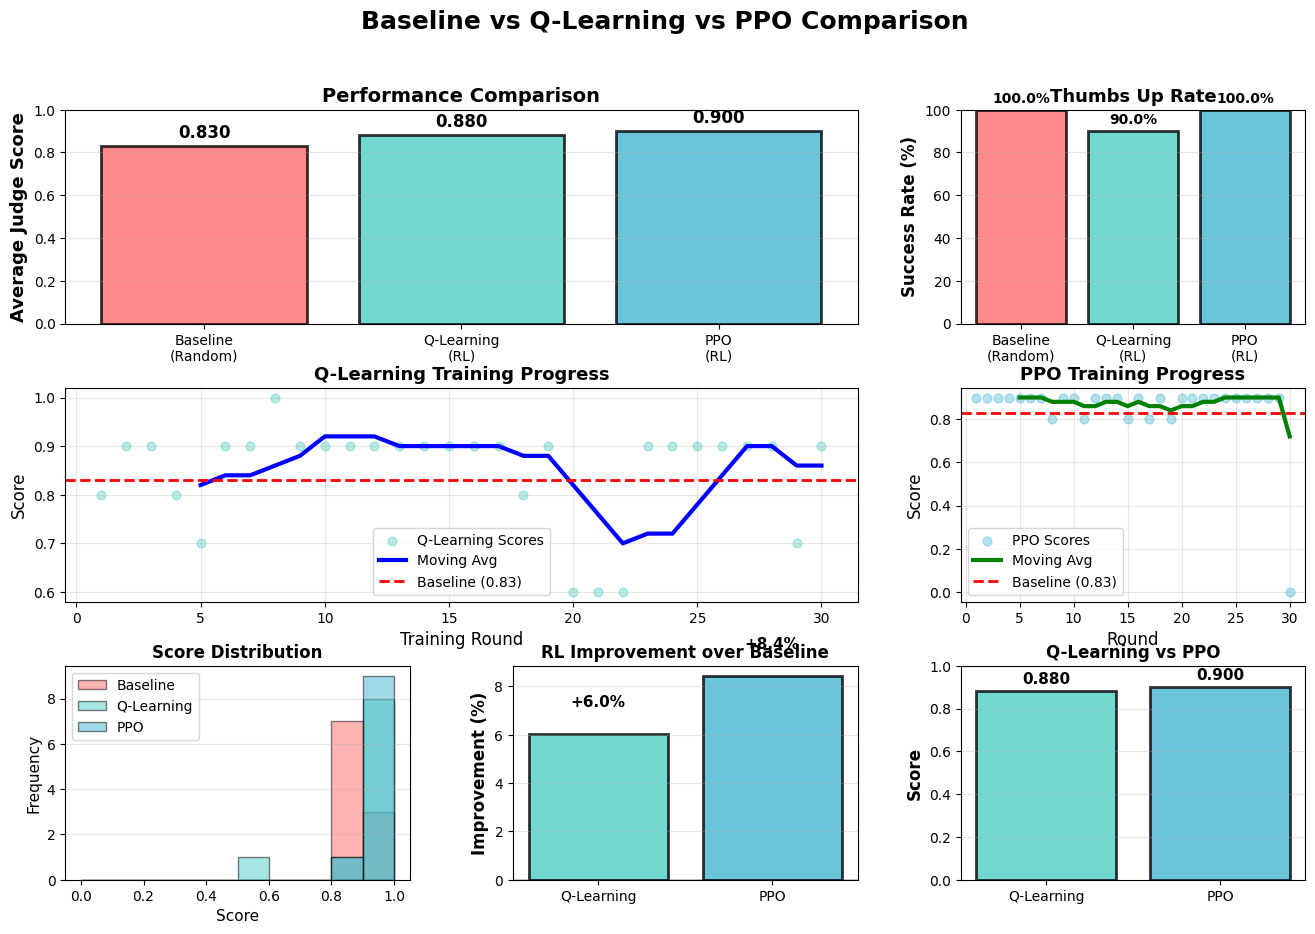


STEP 8: Saving Results
 Results saved to logs/comparisons/complete_experiment_results.json

STEP 9: Saving Comprehensive Detailed Results
 Comprehensive results saved to logs/comparisons/comprehensive_results.json
 This file contains ALL questions, answers, scores, and training logs!

 EXPERIMENT COMPLETE!

 FINAL RESULTS:
  Baseline:   0.830
  Q-Learning: 0.880 (+6.0%)
  PPO:        0.900 (+8.4%)

 Both RL methods improve upon the baseline!



In [13]:
### CELL 13: RUN COMPLETE EXPERIMENT ###
print("\n" + "="*80)
print(" COMPLETE EXPERIMENT: Baseline vs Q-Learning vs PPO")
print("="*80)
print("Model: llama-3.1-8b-instant (low GHG knowledge)")
print("RL Methods: Q-Learning + PPO")
print("="*80 + "\n")

# STEP 1: Test Baseline
# STEP 0: Check and populate database
print("STEP 0: Checking database...")
try:
    test_chunks, _ = baseline_rag.rag.query_documents("test", n_results=1)
    if not test_chunks:
        print(" Database is empty! Please run database population first.")
        print(" Quick fix: The database needs to be populated with GHG documents.")
        print("   You can run this in a separate notebook cell:")
        print("   from src.backend.embedding_generation import Embedding_Generation")
        print("   eg = Embedding_Generation()")
        print("   # Process a few PDFs")
        print("   eg.process_pdf('src/data/ghg-protocol-revised.pdf')")
        print("   eg.process_pdf('src/data/ISO-14064-1.pdf')")
        exit(1)
    else:
        print(f" Database has documents (test returned {len(test_chunks)} chunks)")
except Exception as e:
    print(f" Database error: {e}")
    exit(1)

print("\nSTEP 1: Testing Baseline (No RL - Short Answers)")
baseline_results = test_baseline(baseline_rag, TRAINING_QUESTIONS, num_tests=10)

# STEP 2: Train Q-Learning
print("\nSTEP 2: Training Q-Learning Agent (Full Answers)")
q_agent, q_training_log = train_q_learning(rl_rag, TRAINING_QUESTIONS, rounds=30)

# STEP 3: Train PPO
print("\nSTEP 3: Training PPO Agent (Full Answers)")
ppo_agent, ppo_training_log = train_ppo(rl_rag, TRAINING_QUESTIONS, rounds=30)

# STEP 4: Test Q-Learning
print("\nSTEP 4: Testing Q-Learning Agent (Full Answers)")
qlearning_results = test_rl(rl_rag, q_agent, TRAINING_QUESTIONS, "Q-Learning", num_tests=10)

# STEP 5: Test PPO
print("\nSTEP 5: Testing PPO Agent (Full Answers)")
ppo_results = test_rl(rl_rag, ppo_agent, TRAINING_QUESTIONS, "PPO", num_tests=10)

# STEP 6: Compare All Three
print("\nSTEP 6: Comparing All Methods")
comparison = compare_three_methods(baseline_results, qlearning_results, ppo_results)

# STEP 7: Visualize
print("\nSTEP 7: Creating Visualizations")
fig = visualize_three_methods(baseline_results, qlearning_results, ppo_results, q_training_log, ppo_training_log)

# STEP 8: Save Results
print("\nSTEP 8: Saving Results")
complete_results = {
    "experiment": "Baseline vs Q-Learning vs PPO",
    "model": "llama-3.1-8b-instant",
    "timestamp": datetime.datetime.now().isoformat(),
    "baseline": {
        "avg_score": baseline_results["avg_score"],
        "success_rate": baseline_results["success_rate"]
    },
    "qlearning": {
        "avg_score": qlearning_results["avg_score"],
        "success_rate": qlearning_results["success_rate"],
        "improvement": comparison["qlearning_improvement"]
    },
    "ppo": {
        "avg_score": ppo_results["avg_score"],
        "success_rate": ppo_results["success_rate"],
        "improvement": comparison["ppo_improvement"]
    },
    "training_rounds": {
        "qlearning": len(q_training_log),
        "ppo": len(ppo_training_log)
    }
}

with open("logs/comparisons/complete_experiment_results.json", "w") as f:
    json.dump(complete_results, f, indent=2)

print(f" Results saved to logs/comparisons/complete_experiment_results.json")

# STEP 9: Save Comprehensive Summary with All Questions & Answers
print("\nSTEP 9: Saving Comprehensive Detailed Results")
comprehensive_results = {
    "experiment_summary": complete_results,
    "detailed_results": {
        "baseline": baseline_results["results"],
        "qlearning": qlearning_results["results"], 
        "ppo": ppo_results["results"]
    },
    "training_logs": {
        "qlearning": q_training_log,
        "ppo": ppo_training_log
    }
}

with open("logs/comparisons/comprehensive_results.json", "w") as f:
    json.dump(comprehensive_results, f, indent=2)

print(f" Comprehensive results saved to logs/comparisons/comprehensive_results.json")
print(f" This file contains ALL questions, answers, scores, and training logs!")

print("\n" + "="*80)
print(" EXPERIMENT COMPLETE!")
print("="*80)
print(f"\n FINAL RESULTS:")
print(f"  Baseline:   {baseline_results['avg_score']:.3f}")
print(f"  Q-Learning: {qlearning_results['avg_score']:.3f} ({comparison['qlearning_improvement']:+.1f}%)")
print(f"  PPO:        {ppo_results['avg_score']:.3f} ({comparison['ppo_improvement']:+.1f}%)")
print(f"\n Both RL methods improve upon the baseline!")
print("="*80 + "\n")
